In [ ]:
!pip install pydub
!pip install fastaudio
# If you are using Colab, restart your notebook after running this cell.

In [ ]:
import pandas as pd
import requests
from tqdm import tqdm

country = 'brazil'
response = requests.get(f'https://www.xeno-canto.org/api/2/recordings?query=cnt:{country}')
js = response.json()

df = pd.DataFrame()
for n_page in tqdm(range(1, js["numPages"]+1)):
    response = requests.get(f'https://www.xeno-canto.org/api/2/recordings?query=cnt:{country}&page={n_page}')
    page_json = response.json()
    ids, files, file_names, ens, lengths, gens = [], [], [], [], [], []
    for recording in page_json["recordings"]:
        ids.append(recording["id"])
        files.append(recording["file"])
        file_names.append(recording["file-name"])
        ens.append(recording["en"])
        lengths.append(recording["length"])
        gens.append(recording["gen"])


    df_ = pd.DataFrame.from_records({'id': ids, "file": files, "file-name": file_names, "en": ens, "gen": gens, "length": lengths})
    df = df.append(df_)
    
df.to_csv("birds.csv", index=False)

100%|██████████| 117/117 [05:16<00:00,  2.70s/it]


In [ ]:
from pandas import read_csv
from urllib.request import urlretrieve
from os import listdir, mkdir, path as os_path
from tqdm.notebook import tqdm
from time import sleep

df = read_csv("birds.csv")

#Removing recordings that are not classified
df = df[df['en'] != 'Identity unknown'].copy()
df = df[df['en'] != 'Soundscape'].copy()
#Dropping files of species with less than 100 samples
counts = df['en'].value_counts()
chosen = counts.head(10).index
df = df[df["en"].isin(chosen)]
df.to_csv("to_download.csv", index=False)

print(df.shape)
print(len(df["en"].unique()), "different species")

audio_dir = 'audio_files/'
if not os_path.isdir(audio_dir):
    mkdir(audio_dir)

nots = []

for row in tqdm(df.iterrows(), total=df.shape[0]):
    url = row[1]["file"]
    f_name = str(row[1]["id"]) + row[1]["file-name"][-4:].lower()
    try:
        urlretrieve('https:'+url, filename=audio_dir + f_name)
    except Exception as e:
        print("\nRetrying:", url)
        print(e) 
        sleep(60)
        try:
            urlretrieve('https:'+url, filename=audio_dir + f_name)
        except Exception as ee:
            print("Not downloaded|", f_name)
            print(ee)
            nots.append(row[1]["id"])
            pass

if len(nots) > 0:
    with open('not_downloaded.txt', 'w') as f:
        for item in nots:
            f.write(str(item) + '\n')
    print(str(nots))
else:
    print('All files were successfully downloaded!')

(2144, 6)
10 different species


  0%|          | 0/2144 [00:00<?, ?it/s]

All files were successfully downloaded!


In [ ]:
!pip install pydub
from google.colab import drive
drive.mount('/gdrive')
data_dir = '/gdrive/My Drive/BirdShazam/'
audio_dir = 'audio_files/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
from os import listdir, mkdir, path as os_path
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
from os import listdir, mkdir
import pandas as pd
from tqdm.notebook import tqdm

df = pd.read_csv(data_dir+'to_download.csv')

audio_dir = data_dir+'audio_files/'
#Check downloaded files
df['file-name'] = df['file-name'].str.lower()
df['filename'] = df['id'].astype(str) + df['file-name'].str[-4:]
downloaded = df[df['filename'].isin(files)][['filename', 'en']]
downloaded.to_csv('downloaded.csv', index=False)
# print('Not downloaded:', len(df) - len(downloaded))

train, test = train_test_split(downloaded[['filename', 'en']], stratify=downloaded["en"], test_size=0.1)

def to_wav(filename, n_channels, sample_rate, input_dir, output_dir):
    input_type = filename[-4:].lower()
    if input_type == '.mp3':
        sound = AudioSegment.from_mp3(f"{input_dir}/{filename}")
        new_fn = fn[:-4] + '.wav'
    elif input_type == '.wav':
        sound = AudioSegment.from_wav(f"{input_dir}/{filename}")
        new_fn = filename
    sound = sound.set_channels(n_channels)
    sound.set_frame_rate(sample_rate)
    sound.export(f"{output_dir}/{new_fn}", format="wav")

wav_dir = data_dir+'wav_files/'
if not os_path.isdir(wav_dir):
    mkdir(wav_dir)
    mkdir(wav_dir + 'test/')
    mkdir(wav_dir + 'train/')

In [ ]:
for fn in tqdm(test['filename']):
    to_wav(fn, n_channels=1, sample_rate=16000, input_dir=audio_dir, output_dir=wav_dir+'test')

  0%|          | 0/215 [00:00<?, ?it/s]

In [ ]:
for fn in tqdm(train['filename']):
    to_wav(fn, n_channels=1, sample_rate=16000, input_dir=audio_dir, output_dir=wav_dir+'train')

  0%|          | 0/1929 [00:00<?, ?it/s]

In [ ]:
downloaded = pd.read_csv('downloaded.csv')
downloaded['filename'] = downloaded['filename'].str[:-4] + '.wav'
downloaded.columns = ['filename', 'category']
train_files = listdir('wav_files/train')
test_files = listdir('wav_files/test')
df = downloaded[downloaded['filename'].isin(train_files)]
df_test = downloaded[downloaded['filename'].isin(test_files)]
print(df.shape)
print(df_test.shape)

(1927, 2)
(215, 2)


In [ ]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

torch.cuda.empty_cache()

path = Path('.')
seconds = 10
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512, n_mels=120)
a2s = AudioToSpec.from_cfg(cfg)
item_transforms = [ResizeSignal(seconds*1000), a2s]

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (120) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


In [ ]:
auds = DataBlock(blocks = (AudioBlock(), CategoryBlock),
                 get_x = ColReader("filename", pref=path/"wav_files/train"), 
                 splitter = TrainTestSplitter(random_state=42, stratify=df['category'], test_size=0.2),
                 item_tfms = item_transforms,
                 get_y = ColReader("category")
                 )

In [ ]:
batch_size = 64
dbunch = auds.dataloaders(df, bs=batch_size, shuffle=False)

In [ ]:
set_seed(42,True)
dbunch.rng.seed(42)

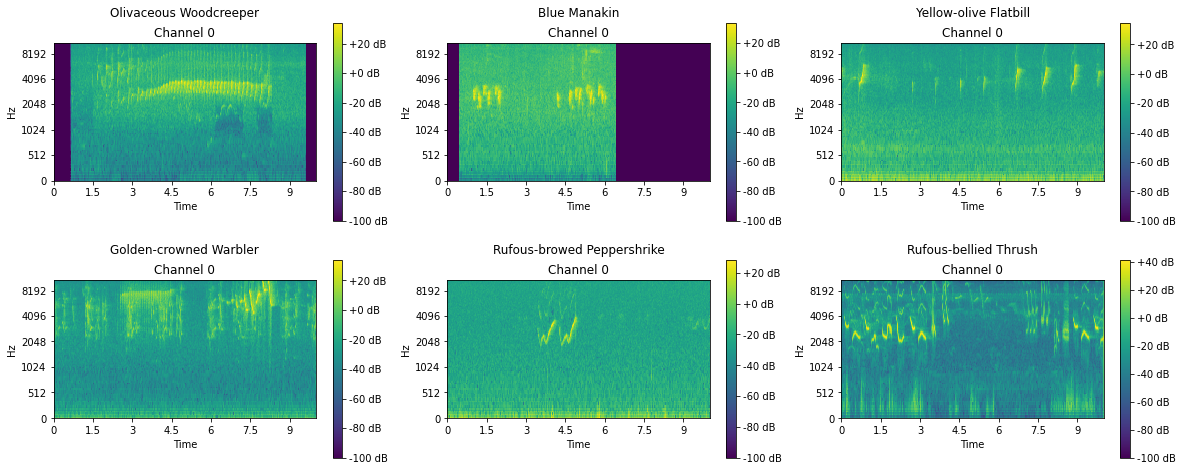

In [ ]:
dbunch.show_batch(figsize=(20, 8), nrows=2, ncols=3)

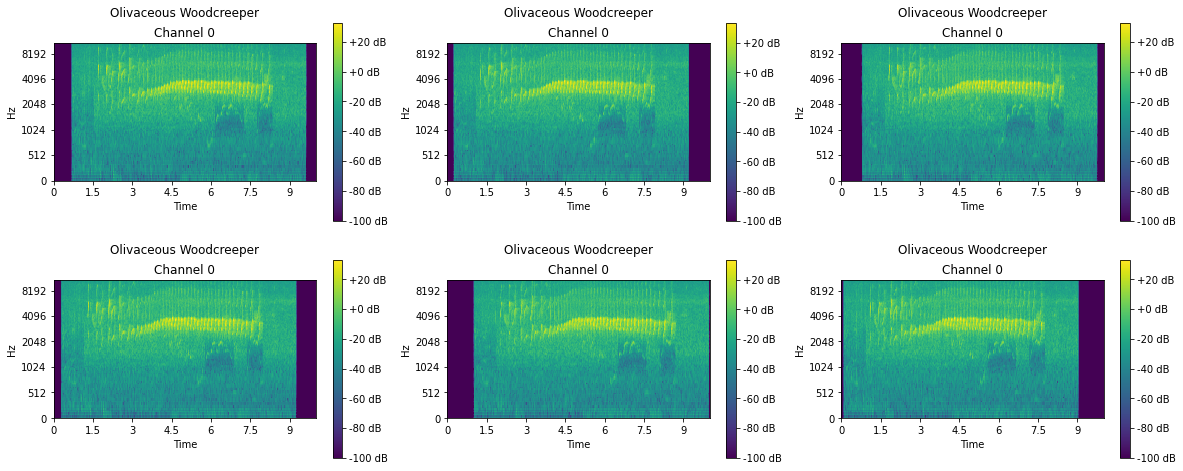

In [ ]:
dbunch.show_batch(figsize=(20, 8), nrows=2, ncols=3, unique=True)

In [ ]:
model_type = resnet34
learn = cnn_learner(dbunch, 
            model_type,
            n_in=1,  # <- This is the only audio specific modification here
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])

0.0006918309628963471


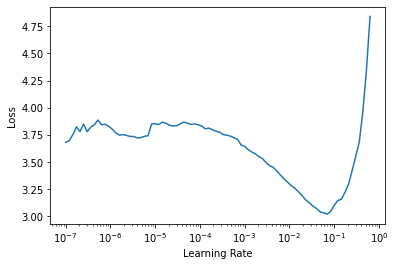

In [ ]:
lr = learn.lr_find()[0]/10
print(lr)

In [ ]:
callbacks = [SaveModelCallback(), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2)]
learn.fine_tune(20, wd=0.1, base_lr=lr, cbs=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,3.327838,2.177061,0.253886,02:03


Better model found at epoch 0 with valid_loss value: 2.177061080932617.


epoch,train_loss,valid_loss,accuracy,time
0,2.656624,1.947843,0.341969,02:06
1,2.503793,1.735478,0.432642,02:07
2,2.323141,1.639165,0.474093,02:07
3,2.103050,1.438343,0.533679,02:05
4,1.852982,1.272471,0.588083,02:06
5,1.639469,1.199205,0.626943,02:06
6,1.423063,1.089285,0.668394,02:07
7,1.259160,1.066277,0.678756,02:08
8,1.080621,0.977298,0.683938,02:07
9,0.920666,0.977340,0.683938,02:06


Better model found at epoch 0 with valid_loss value: 1.9478429555892944.
Better model found at epoch 1 with valid_loss value: 1.7354780435562134.
Better model found at epoch 2 with valid_loss value: 1.639164686203003.
Better model found at epoch 3 with valid_loss value: 1.4383426904678345.
Better model found at epoch 4 with valid_loss value: 1.2724714279174805.
Better model found at epoch 5 with valid_loss value: 1.1992045640945435.
Better model found at epoch 6 with valid_loss value: 1.0892845392227173.
Better model found at epoch 7 with valid_loss value: 1.066277265548706.
Better model found at epoch 8 with valid_loss value: 0.977298378944397.
Better model found at epoch 10 with valid_loss value: 0.9451090693473816.
Epoch 10: reducing lr to 2.493979657431062e-05
Better model found at epoch 11 with valid_loss value: 0.8938799500465393.
Epoch 12: reducing lr to 1.7451190212698663e-05
Better model found at epoch 13 with valid_loss value: 0.8031873106956482.
Epoch 15: reducing lr to 6.63

In [ ]:
learn.save('model0')

Path('models/model0.pth')

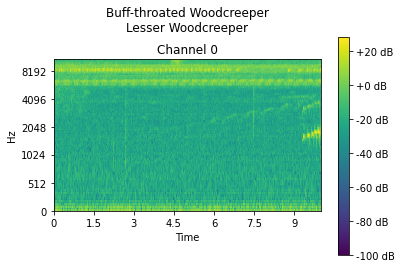

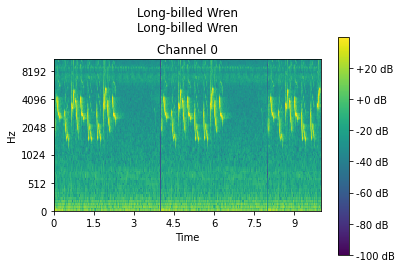

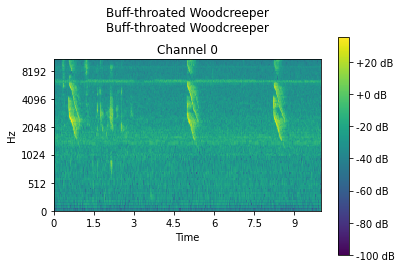

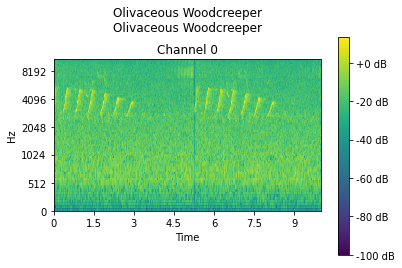

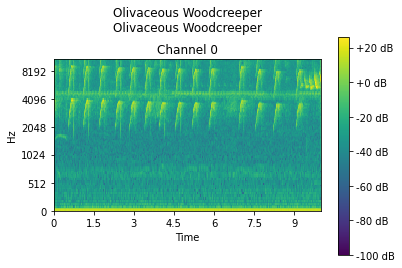

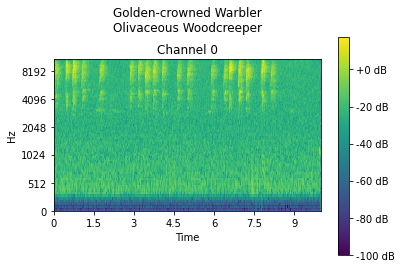

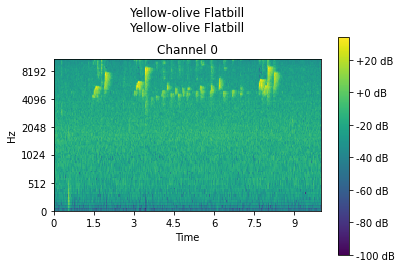

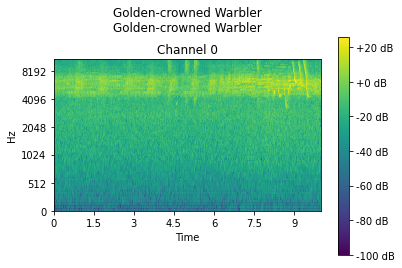

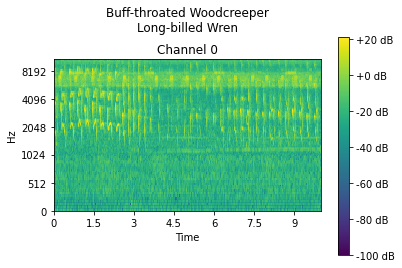

In [ ]:
learn.show_results()

[('Rufous-bellied Thrush', 'Pale-breasted Thrush', 8),
 ('Olivaceous Woodcreeper', 'Blue Manakin', 7),
 ('Pale-breasted Thrush', 'Long-billed Wren', 7),
 ('Rufous-bellied Thrush', 'Rufous-browed Peppershrike', 6),
 ('Yellow-olive Flatbill', 'Golden-crowned Warbler', 6),
 ('Yellow-olive Flatbill', 'Blue Manakin', 5),
 ('Blue Manakin', 'Long-billed Wren', 4),
 ('Olivaceous Woodcreeper', 'Lesser Woodcreeper', 4),
 ('Pale-breasted Thrush', 'Rufous-bellied Thrush', 4),
 ('Rufous-browed Peppershrike', 'Rufous-bellied Thrush', 4)]

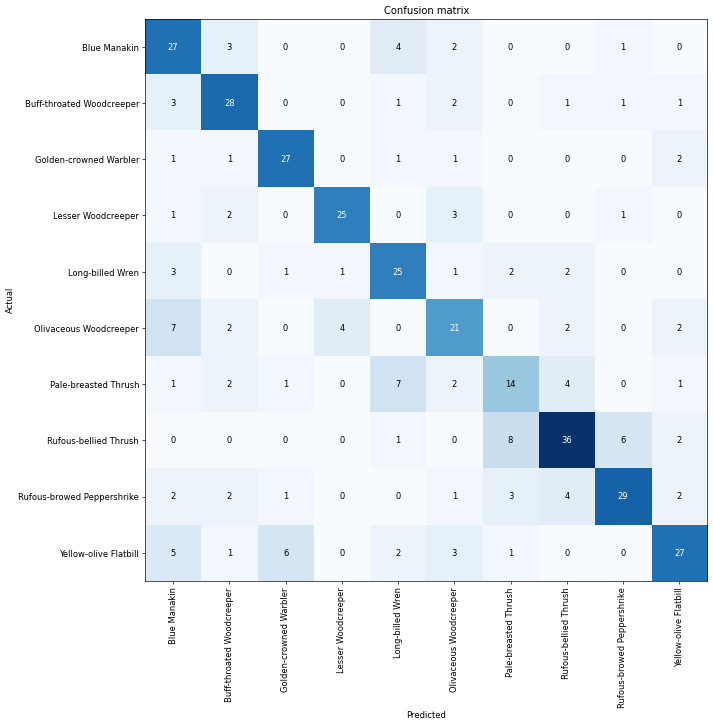

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused()[:10]

In [ ]:
learn.export(path/f'model_bs{batch_size}_{seconds}s.model')

In [ ]:
model_type = resnet34
learn = cnn_learner(dbunch, 
            model_type,
            n_in=1,  # <- This is the only audio specific modification here
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])
learn.load('model')

In [ ]:
# le0 = load_learner('models/model1.pth', cpu=False)

In [ ]:
# le0.predict(dbunch_test.valid_ds)

In [ ]:
auds_test = DataBlock(blocks = (AudioBlock(sample_rate=16000, crop_signal_to=7000), CategoryBlock),  
                 get_x = ColReader("filename", pref=path/"wav_files/test"),
                 item_tfms = item_transforms,
                 get_y = ColReader("category")
                 )

dbunch_test = auds_test.dataloaders(df_test, bs=batch_size, shuffle=False)

In [ ]:
learn.data = dbunch_test
preds, y = learn.get_preds()
acc = accuracy(preds, y)
acc

In [ ]:
acc = accuracy(preds, y)
acc

In [ ]:
# Set the validation set of the learner by the test data you created
learn.data.valid_dl = data_test.valid_dl

# Now y refers to the actual labels in the data set
preds, y = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
learn2 = copy(learn)

In [ ]:
learn.save('model0')